In [2]:
! pip install yfinance

In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

#in practice do not supress these warnings, they carry important information about the status of your model
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Simulate Buying and Selling Stock Using ARMA(p,q)

In [4]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit(maxiter=200)

                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

# Read Data

In [5]:
tickerSymbol = 'AAPL'
data = yf.Ticker(tickerSymbol)


In [6]:
prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()

            Close
Date             
2023-01-01    144
2023-01-02    147
2023-01-03    164
2023-01-04    167
2023-01-05    167
2023-01-06    109
2023-01-07    183
2023-01-08    121
2023-01-09    136
2023-01-10    187
            Close  Pct_Change
Date                         
2023-01-01    144         NaN
2023-01-02    147    0.020833
2023-01-03    164    0.115646
2023-01-04    167    0.018293
2023-01-05    167    0.000000
2023-01-06    109   -0.347305
2023-01-07    183    0.678899
2023-01-08    121   -0.338798
2023-01-09    136    0.123967
2023-01-10    187    0.375000


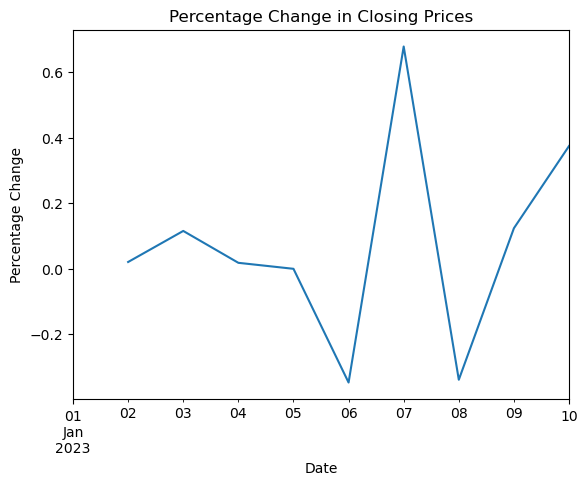

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Creating a date range
dates = pd.date_range(start='2023-01-01', periods=10, freq='D')

# Generating random closing prices
np.random.seed(0)
closing_prices = np.random.randint(100, 200, size=(10,))

# Creating a DataFrame
df = pd.DataFrame({'Date': dates, 'Close': closing_prices})
df.set_index('Date', inplace=True)

print(df)

df['Pct_Change'] = df['Close'].pct_change()
print(df)

df['Pct_Change'].plot(title="Percentage Change in Closing Prices")
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.show()


In [8]:
closing_prices

array([144, 147, 164, 167, 167, 109, 183, 121, 136, 187])

Text(0, 0.5, 'Prices')

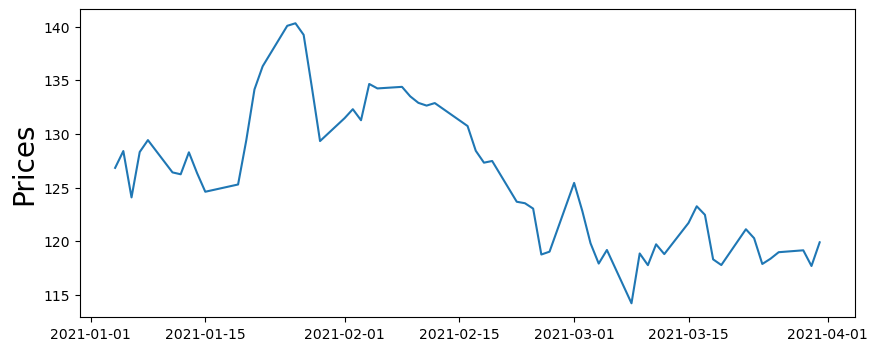

In [9]:
plt.figure(figsize=(10,4))
plt.plot(prices)
plt.ylabel('Prices', fontsize=20)

Text(0, 0.5, 'Return')

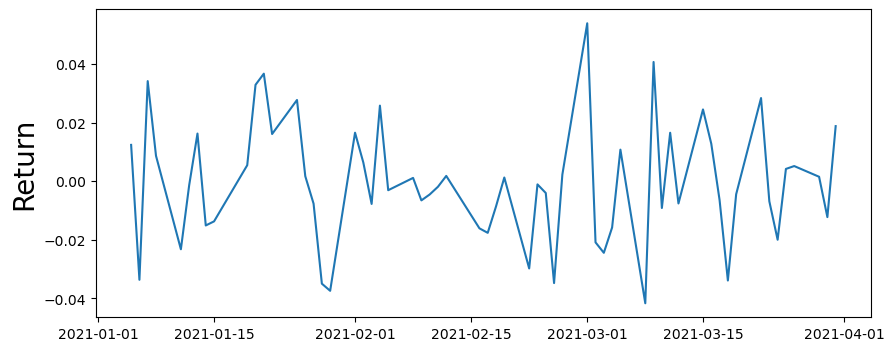

In [10]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

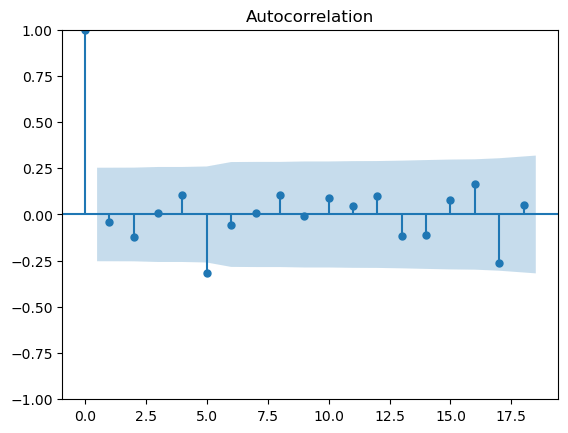

In [11]:
plot_acf(returns)
plt.show()

A lag of 5 days we have a strong signal on the ACF. And ACF forms the MA part of our model so we might want to pick MA(5) model

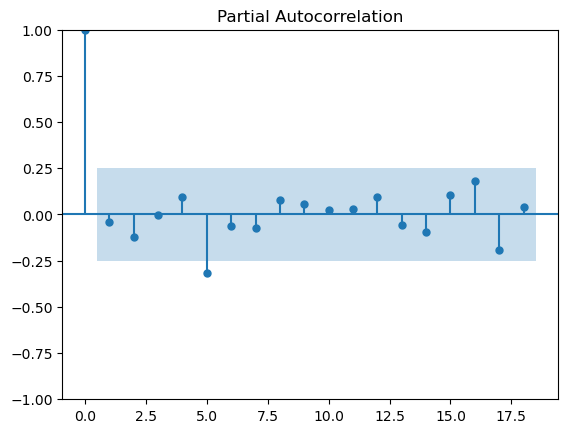

In [20]:
plot_pacf(returns)
plt.show()

It forms the AR part of the model. There is a spike at five.

# Baseline Model : Random Buying 

In [22]:
run_simulation(returns, prices, 100, 0.5, None, verbose=False)

  7%|▋         | 3/46 [00:21<05:13,  7.28s/it]

In [14]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(1000)]

  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [00:00<00:00, 21222.97it/s]


C:\Users\zsombor.veres-lakos\AppData\Local\Temp\ipykernel_25224\2783033276.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_amts)


c:\Users\zsombor.veres-lakos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Avg: $95.24\nSD: $6.22')

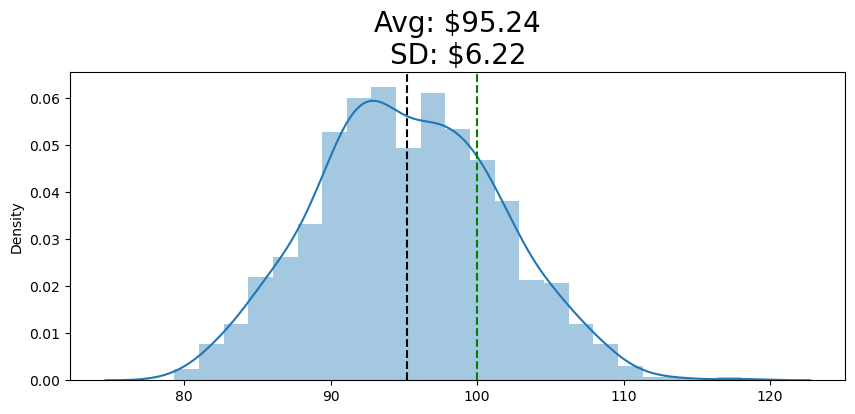

In [15]:
plt.figure(figsize=(10,4))
sns.distplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

# If Last Return was Positive, Buy

  0%|          | 0/46 [00:00<?, ?it/s]C:\Users\zsombor.veres-lakos\AppData\Local\Temp\ipykernel_25224\2958298199.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  or (order == 'last' and curr_data[-1] > 0)):
100%|██████████| 46/46 [00:00<00:00, 9199.35it/s]


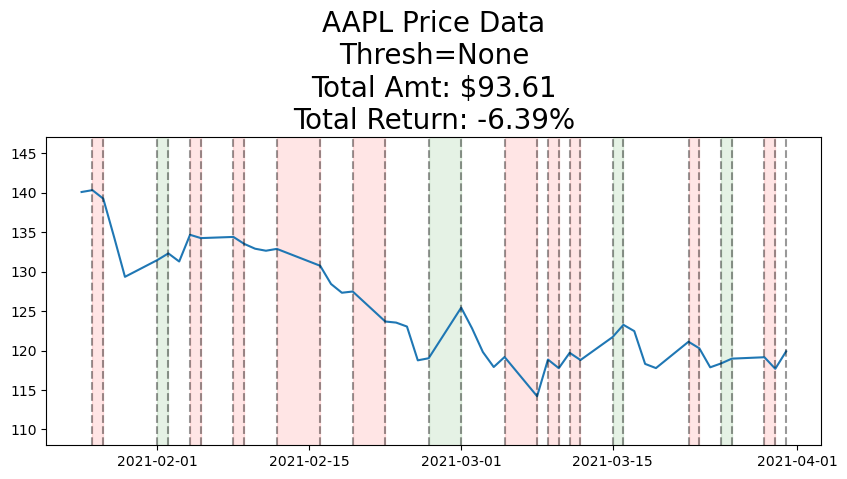

93.60987957996338

In [16]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

# Try AR(1) Model

100%|██████████| 46/46 [00:00<00:00, 22927.87it/s]


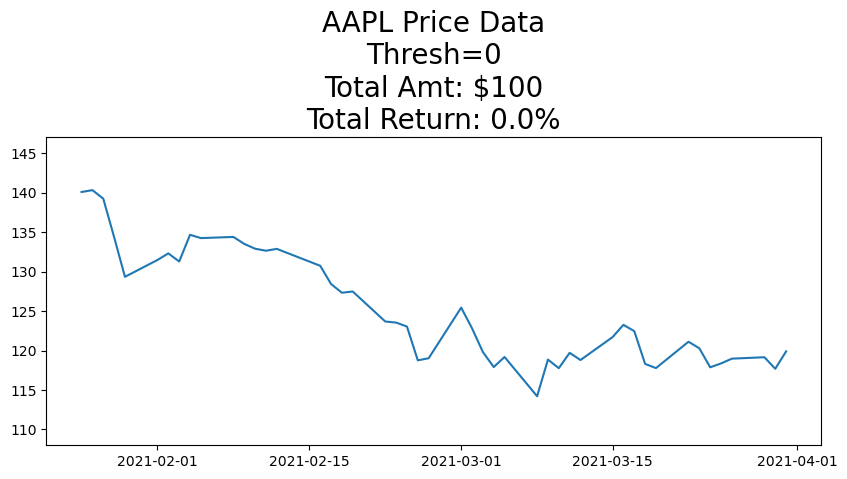

100%|██████████| 46/46 [00:00<00:00, 22052.58it/s]


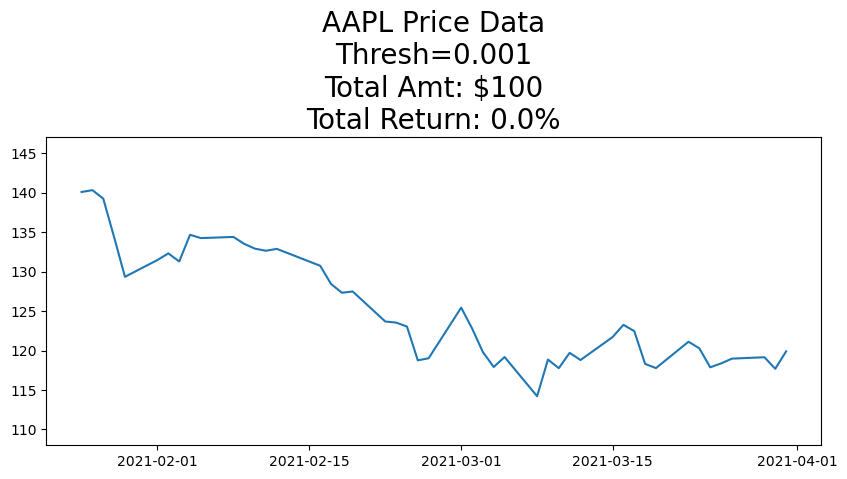

100%|██████████| 46/46 [00:00<00:00, 23004.41it/s]


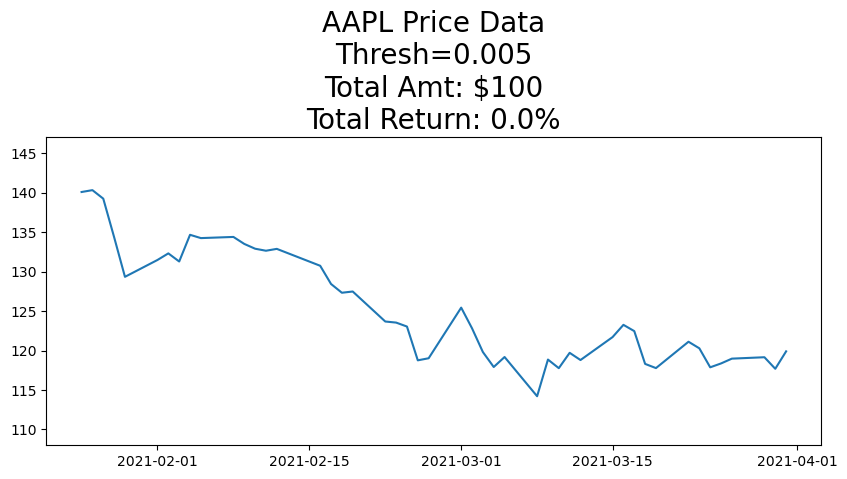

In [17]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

# Try AR(5) Model

100%|██████████| 46/46 [00:00<00:00, 23012.64it/s]


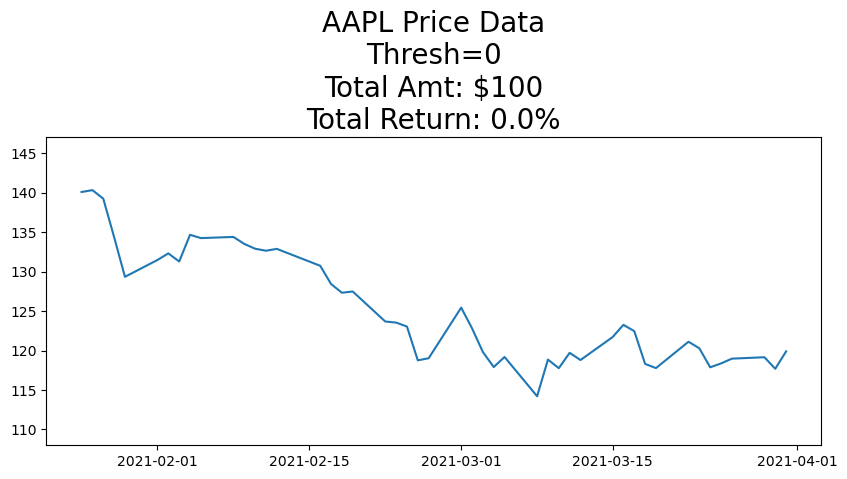

100%|██████████| 46/46 [00:00<00:00, 29202.06it/s]


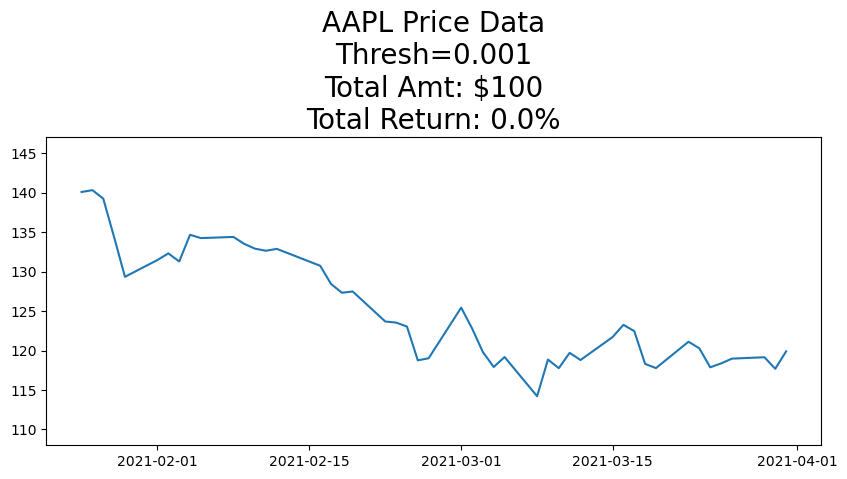

100%|██████████| 46/46 [00:00<00:00, 23004.41it/s]


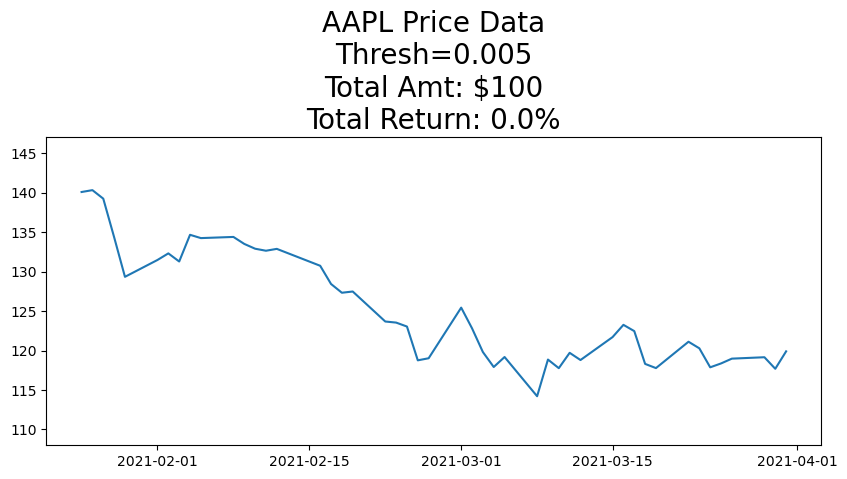

In [18]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,0), thresh, verbose=False)

# Try ARMA(5,5) Model

100%|██████████| 46/46 [00:00<00:00, 21907.34it/s]


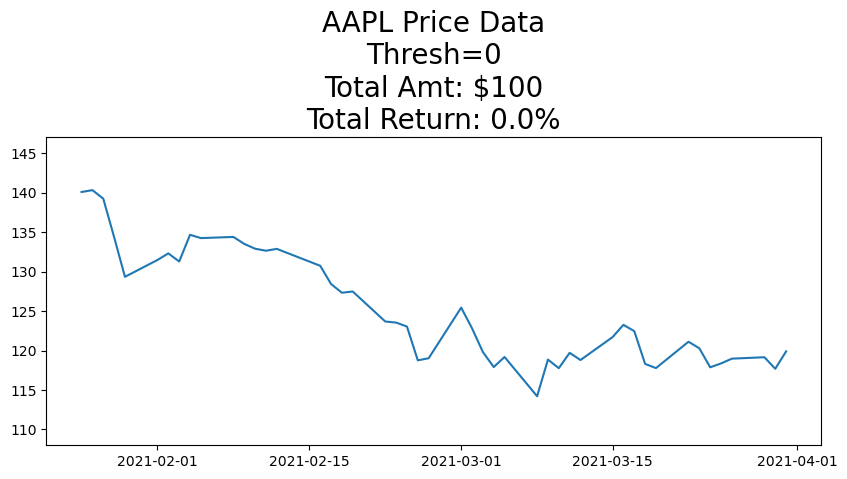

100%|██████████| 46/46 [00:00<00:00, 17535.03it/s]


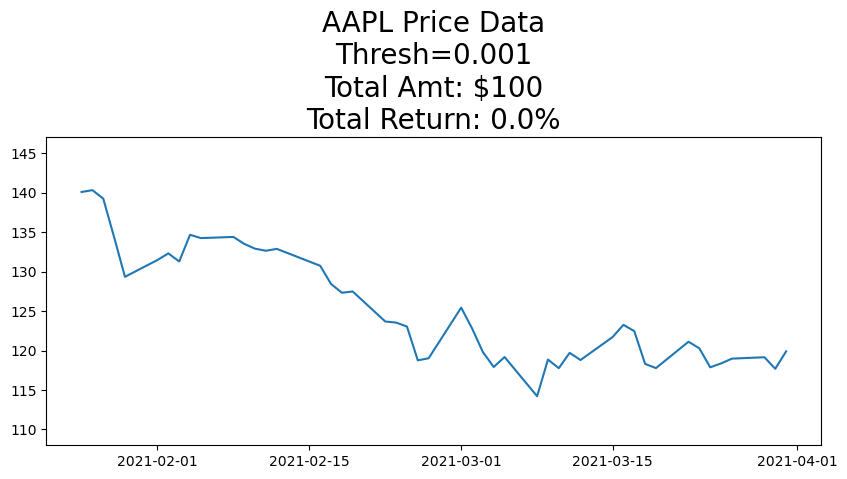

100%|██████████| 46/46 [00:00<00:00, 29838.85it/s]


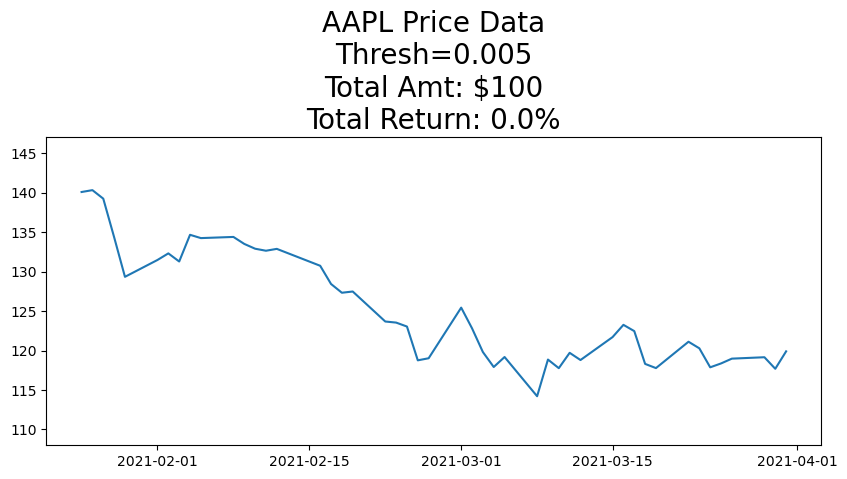

In [19]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (5,0,5), thresh, verbose=False)